# CmdStanPy Tutorial


## Workflow Outline

Given a dataset and a model specification written as a Stan program, the CmdStanPy workflow is:

### Assemble input data as either:
  + A Python `dict` object consisting of key-value pairs where the key corresponds
 to Stan data variables and the value is of the correct type and shape.
  + An existing data file on disk in either JSON or Rdump format.

### Compile the model
  + The `CmdStanModel` object stores the filepath of the Stan program.
  + The `compile` method translates the Stan program to C++ then calls the C++ compiler which creates the executable program.

### Fit the model conditioned on the data to obtain an estimate of the posterior

#### Run the NUTS-HMC sampler to obtain the full posterior density

  + The `CmdStanModel` class method `sample` invokes Stan's NUTS-HMC sampler which conditions the model on the input data and returns a `CmdStanMCMC` object. The `CmdStanMCMC` object contains the set of draws from the posterior plus metadata.
  + Runs any number of chains - default is 4 chains.
  + The output of each chain is stored on disk as a Stan csv file.

#### Estimate the mode of the posterior density via optimization

  + The `CmdStanModel` class method `optimize` runs one of Stan's [optimization](https://mc-stan.org/docs/reference-manual/optimization-algorithms-chapter.html) algorithms to obtains an estimate of the mode of the posterior density.

### Summarize and check the sample

   + The `CmdStanMCMC` class method `summary` invokes CmdStan's `stansummary` utility. Returns a Pandas DataFrame with estimates of posterior means, standard deviations, Monte-Carlo standard error, effective sample size, and convergence diagnostic statistic for all parameters in the model.
   + The `CmdStanMCMC` class method `diagnose` invokes CmdStan's `diagnose` utility which checks for the following problems:
    + transitions that hit the maximum treedepth
    + divergent transitions
    + low E-BFMI values (sampler transitions HMC potential energy)
    + low effective sample sizes
    + high R-hat values
   + See the Stan reference manual section on [posterior analysis](https://mc-stan.org/docs/reference-manual/analysis-chapter.html) for further details.

###  Assemble the sample in-memory
  + The resulting sample is accessed via the `CmdStanMCMC` object:
    + `sample`  - all draws from all chains, stored as a 3-D numpy.ndarray.
    + `chains` - number of chains run by sampler
    + `draws` - draws per chain
    + `column_names` - names of the parameters, transformed parameters, and generated quantities variables returned in each draw
    + `csv_files` - list of Stan csv output files which comprise the sample
  + The method `get_drawset` flattens the 3-D sample array into a 2-D pandas.DataFrame for downstream analysis.


## Installation

* Install Python package from PyPI or directly from GitHub:

  + `pip install --upgrade cmdstanpy`
  + `pip install -e git+https://github.com/stan-dev/cmdstanpy`


* CmdStanPy uses CmdStan directly to compile and run Stan programs, therefore CmdStan must be installed locally.

  + if you have a working installation of CmdStan, set environment variable `CMDSTAN` to the full path to the top-level CmdStan directory.
  
  + if you don't already have CmdStan installed, run Python script `install_cmdstan` which downloads and compiles the latest release from https://github.com/stan-dev/cmdstan/releases.  By default this installs the latest version of CmdStan in the location `~/.cmdstanpy`.  Flags -d and -v are used to specify the directory and version, respectively.


## Hello World:  Compile and run CmdStan example model `bernoulli.stan`

Every CmdStan release has an `examples/bernoulli` directory which contains the Stan model and test data files.  In this example we compile the model and run the sampler on the model and data.

### Import relevant classes and methods

In [1]:
import os
import os.path
from cmdstanpy import CmdStanModel, cmdstan_path

### Compile the model

The CmdStanPy directory `examples/bernoulli` contains the model and data files.

In [2]:
bernoulli_dir = os.path.join(cmdstan_path(), 'examples', 'bernoulli')
bernoulli_path = os.path.join(bernoulli_dir, 'bernoulli.stan')

First we create a `CmdStanModel` object for the specified Stan program file, then we call the `compile` method to create the corresponding C++ executable program.

In [4]:
bernoulli_model = CmdStanModel(stan_file=bernoulli_path)
print(bernoulli_model)

INFO:cmdstanpy:stan to c++ (/Users/mitzi/.cmdstanpy/cmdstan-2.20.0/examples/bernoulli/bernoulli.hpp)
INFO:cmdstanpy:compiling c++
INFO:cmdstanpy:compiled model file: /Users/mitzi/.cmdstanpy/cmdstan-2.20.0/examples/bernoulli/bernoulli


CmdStanModel(name=bernoulli,  stan_file="/Users/mitzi/.cmdstanpy/cmdstan-2.20.0/examples/bernoulli/bernoulli.stan", exe_file="/Users/mitzi/.cmdstanpy/cmdstan-2.20.0/examples/bernoulli/bernoulli")


### Run the HMC-NUTS sampler on the model and data

Input data is either a Python `Dict` with entries corresponding to input data values, or it can be a file in JSON or Rdump format.

In [5]:
bern_json = os.path.join(bernoulli_dir, 'bernoulli.data.json')

If a `Dict` is specified, CmdStanPy writes it to a temp file in JSON format.

In [6]:
bern_data = { "N" : 10, "y" : [0,1,0,0,0,0,0,0,0,1] }

The `CmdStanModel` method `sample` runs the NUTS-HMC sampler and returns a `CmdStanMCMC` object.  By default, `sample` runs 4 sampler chains.

In [7]:
bern_fit = bernoulli_model.sample(data=bern_data)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 4


### Access the sample: the `CmdStanMCMC` object attributes and methods

#### Summarize the results

The `CmdStanMCMC` method `summary` returns output of CmdStan bin/stansummary as pandas.DataFrame.  The `summary` report provides estimates of both the parameter value and the goodness of fit.

In [8]:
bern_fit.summary()

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
lp__,-7.267660,0.016792,0.710076,-8.741910,-6.98903,-6.750200,1788.22,12930.90,1.00091
theta,0.251933,0.003337,0.121042,0.084919,0.23354,0.475669,1315.97,9516.05,1.00363


#### Run sampler diagnostics

The `CmdStanMCMC` method `diagnose` prints the output of CmdStan bin/stansummary to the console.  This is useful when the summary report shows `R_hat` values outside of the range of .99 to 1.01, or the number of effective samples (`N_eff` value) is below 5% of the total draws in the sample. 

In [9]:
bern_fit.diagnose()


Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory for all transitions.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.


'Processing csv files: /var/folders/sc/0f0wdc_11_xgjs2v52g20fvr0000gn/T/tmpcu006e0e/stan-bernoulli-Method.SAMPLE-1-aszft12v.csv, /var/folders/sc/0f0wdc_11_xgjs2v52g20fvr0000gn/T/tmpcu006e0e/stan-bernoulli-Method.SAMPLE-2-r838n4df.csv, /var/folders/sc/0f0wdc_11_xgjs2v52g20fvr0000gn/T/tmpcu006e0e/stan-bernoulli-Method.SAMPLE-3-pyop7x1l.csv, /var/folders/sc/0f0wdc_11_xgjs2v52g20fvr0000gn/T/tmpcu006e0e/stan-bernoulli-Method.SAMPLE-4-z74wnt9b.csv\n\nChecking sampler transitions treedepth.\nTreedepth satisfactory for all transitions.\n\nChecking sampler transitions for divergences.\nNo divergent transitions found.\n\nChecking E-BFMI - sampler transitions HMC potential energy.\nE-BFMI satisfactory for all transitions.\n\nEffective sample size satisfactory.\n\nSplit R-hat values satisfactory all parameters.\n\nProcessing complete, no problems detected.'

#### Assemble all draws from all chains as an in-memory pandas DataFrame

The `CmdStanMCMC` method `get_drawset` returns a pandas.DataFrame, one draw per row.

In [10]:
bern_drawset = bern_fit.get_drawset()

By default, `get_drawset` returns a DataFrame which contains all columns from the sampler's csv output file, i.e., it contains both the sampler state and the values for all parameter, transformed parameter, and generated quantities variables.

In [11]:
bern_drawset.shape, bern_drawset.columns

((4000, 8),
 Index(['lp__', 'accept_stat__', 'stepsize__', 'treedepth__', 'n_leapfrog__',
        'divergent__', 'energy__', 'theta'],
       dtype='object'))

The `get_drawset` function argument `params` takes a list of parameter or column names:

In [12]:
thetas = bern_fit.get_drawset(params=['theta'])
thetas.shape


(4000, 1)

In [13]:
thetas[0:3]

,theta
0,0.246078
1,0.254398
2,0.326366


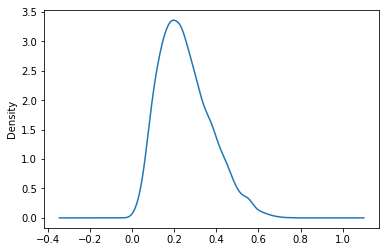

In [15]:
bern_drawset.theta.plot.density()

The `CmdStanMCMC` property `sample` is a 3-D numpy ndarray which contains all draws across all chains.  This array is created only as needed; therefore the first time that this property is accessed CmdStanPy will read in the contents of the sampler's csv output files.  Because the csv output files also contain stepsize and metric information, the `stepsize` and `metric` arrays will also be created.

The numpy ndarray is stored column major format so that values for each parameter are stored contiguously in memory, likewise all draws from a chain are contiguous.  Thus the dimensions of the ndarray are arranged as follows:  (draws, chains, columns):

In [ ]:
bern_fit.sample.shape

Python's index slicing operations can be used to access the information by chain.
For example, to select all draws and all output columns from the first chain,
we specify the chain index (2nd index dimension).  As arrays indexing starts at 0,
the index '0' corresponds to the first chain in the ``RunSet``.

The following expression selects the first 3 draws from chain 1 for the parameter `theta`:

In [16]:
bern_fit.column_names[7], bern_fit.sample[0:3,0,7]

('theta', array([0.246078, 0.254398, 0.326366]))

#### Get HMC sampler tuning parameters

##### stepsize

The `CmdStanMCMC` property `stepsize` property is a 1-D numpy ndarray which contains the stepsize used by the sampler for each chain.  This array is created at the same time as the `sample` and `metric` arrays are created.

At the end of adaptation, the stepsize for the 4 chains in this example is:

In [17]:
bern_fit.stepsize

array([0.948194, 0.96125 , 1.06474 , 1.17857 ])

#### metric_type, metric

The `metric` property is an numpy ndarray which contains the metric used by the sampler for each chain.  This array is created at the same time as the `sample` and `stepsize` arrays are created.

At the end of adaptation, the metric for the 4 chains in this example is:

In [18]:
bern_fit.metric_type,  bern_fit.metric

('diag_e', array([[0.512243],
        [0.584738],
        [0.390916],
        [0.508692]]))